In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=00fdaeff631fb3cd28003f08940fa6db9838407e8a43d1399998de7d73c06b84
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

In [ ]:
def printmg():
  GPUs = GPU.getGPUs()
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printmg()

In [ ]:
import tensorflow as tf
import numpy as np
import os
import io
import time
import random
import shutil
from IPython.display import clear_output
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Activation, Dense, LeakyReLU, PReLU, ReLU, BatchNormalization,Embedding,Attention,LSTM,TimeDistributed, Bidirectional,Input 
from tensorflow.keras.layers import Lambda, Flatten, add, Conv1D, RNN, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K

In [ ]:
from environment2 import *
from service_batch_generator import *
%matplotlib inline

In [ ]:
num_bins=6
bin_sizes_vol = [600,500,400,300,200,100]
bin_sizes_wt = [600,500,400,300,200,100]
num_descriptors = 20
num_ids = 4
size_ranges =  [1,200, 1,200]
cost_ranges = [100,500]
drop_off = 20 
max_cons = 2
batch_size = 5
min_length = 2
max_length = 12

In [ ]:
env = Environment(num_bins,bin_sizes_vol,bin_sizes_wt,num_descriptors,num_ids,size_ranges,cost_ranges,drop_off,max_cons)

In [ ]:
services = ServiceBatchGenerator(batch_size,min_length, max_length, num_descriptors)

In [ ]:
envs = []
for i in range(batch_size):
  env = Environment(num_bins,bin_sizes_vol,bin_sizes_wt,num_descriptors,num_ids,size_ranges,cost_ranges,drop_off,max_cons)
  env.get_service_propertieses()
  envs.append(env)

In [ ]:
env.get_service_propertieses()

In [ ]:
services.getNewState()

In [ ]:
def vector_embedding_final(inputBatch, env):
    """ One-Hot Vector embedding """

    state_size_sequence = inputBatch.maxServiceLength
    state_size_embeddings = env.num_ids
    remaining_embeddings = 1 + 1 + 1 + env.numBins # wt + vol + combine + (cost*do_not_include)

    state = np.zeros((inputBatch.batchSize, state_size_sequence, state_size_embeddings+remaining_embeddings), dtype='int32')

    for batch in range(inputBatch.batchSize):
        for i in range(inputBatch.serviceLength[batch]):

            # Packet embeddings OH
            # Packet1 {1,0,0,0,0,0,0,0}
            # Packet2 {0,1,0,0,0,0,0,0}
            # ...
            # Packet8 {0,0,0,0,0,0,0,1}

            c_id = env.service_properties[inputBatch.state[batch][i]]["id"]
            pkt_vol = env.service_properties[inputBatch.state[batch][i]]["vol"]
            pkt_weight = env.service_properties[inputBatch.state[batch][i]]["weight"]
            combine = env.service_properties[inputBatch.state[batch][i]]["combine"]
            state[batch][i][c_id] = 1
            state[batch][i][state_size_embeddings] = pkt_weight
            state[batch][i][state_size_embeddings+1] = pkt_vol
            state[batch][i][state_size_embeddings+2] = combine

            #multiply do_not_inc with costs
            cost_embeddings=[env.service_properties[inputBatch.state[batch][i]]["do_not_inc"][j] *
               env.service_properties[inputBatch.state[batch][i]]["pkt_bin_costs"][j]
               for j in range(len(env.service_properties[inputBatch.state[batch][i]]["do_not_inc"]))]

            for k in range(len(cost_embeddings)):
                state[batch][i][state_size_embeddings + 3+k] = cost_embeddings[k]

    return state

In [ ]:
input_state = vector_embedding_final(services, env)

In [ ]:
for i in range(5):
  print(len(envs[i].service_properties))
  for i in range(20):
    print(envs[0].service_properties[i])

20
{'id': 0, 'vol': 24, 'weight': 186, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [121, 259, 355, 452, 114, 292]}
{'id': 0, 'vol': 165, 'weight': 67, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [121, 259, 355, 452, 114, 292]}
{'id': 0, 'vol': 32, 'weight': 161, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [121, 259, 355, 452, 114, 292]}
{'id': 0, 'vol': 56, 'weight': 37, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [121, 259, 355, 452, 114, 292]}
{'id': 0, 'vol': 116, 'weight': 18, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [121, 259, 355, 452, 114, 292]}
{'id': 1, 'vol': 77, 'weight': 174, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [404, 221, 396, 267, 417, 273]}
{'id': 2, 'vol': 127, 'weight': 89, 'combine': 1, 'do_not_inc': array([1, 1, 1, 1, 1, 1]), 'pkt_bin_costs': [164, 405, 384, 229, 157, 496]}
{'id': 2, 'vol': 5

In [ ]:
input_state

array([[[  1,   0,   0,   0,  76, 141,   1, 103, 246, 102, 104, 131,
         323],
        [  1,   0,   0,   0,  72,  24,   1, 103, 246, 102, 104, 131,
         323],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       

In [ ]:
class Agent(object):
  
  def __init__(self, batch_size, vocab_size, embedding_dim, output_dim):
    
    #vocab_size, embedding_dim, enc_units, batch_sz 
    self.batch_sz = batch_size
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.output_dim = output_dim
  

  def estimator(self):
    inp = Input(shape = (1), name = 'input')
    dspace = Input(shape = (self.output_dim), name = 'space')
    init = Input(shape = (1), name = 'init')
    space = Dense(128, activation = 'tanh')(dspace)
    f_h_state = Dense(128, activation = 'tanh')(init)
    f_c_state = Dense(128, activation = 'tanh')(init)
    b_h_state = Dense(128, activation = 'tanh')(init)
    b_c_state = Dense(128, activation = 'tanh')(init)
    f_state = Dense(128, activation = 'tanh')(init)
    b_state = Dense(128, activation = 'tanh')(init)
    model = Embedding(self.vocab_size, self.embedding_dim)(inp)
    model = Bidirectional(LSTM(128,return_sequences = True, recurrent_initializer='glorot_uniform'))(model, initial_state=[f_h_state, f_c_state, b_h_state, b_c_state])
    model = Bidirectional(LSTM(128, recurrent_initializer='glorot_uniform'))(model, initial_state=[f_state, space, b_state, space])
    model = Dense(128, activation = 'relu')(model)
    model = Dense(self.output_dim, activation = 'relu')(model)
    val = Model(inputs = [inp, dspace, init], outputs = model)
    return val

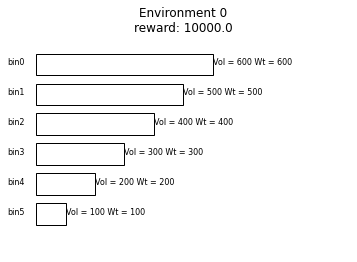

In [ ]:
env.render(None)